# Intro to Machine Learning: Identifying Fraud from Enron Email

> Udacity Data Analyst Nanodegree: _Project 5_
>
> Author: _Ke Zhang_
>
> Submission Date: _2017-04-12_ (Revision 2)

## Abstract

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives.

## Content

- [Question 1: Explore Dataset & Define Questions](#Question-1:-Explore-Dataset-&-Define-Questions)
    - [Data Preparation and Preview](#Data-Preparation-and-Preview)
    - [Outlier Investigation](#Outlier-Investigation)
- [Question 2: Select & Engineer Features](#Question-2:-Select-&-Engineer-Features)
    - [Feature Creation](#Feature-Creation)
    - [Feature Exploration](#Feature-Exploration)
    - [Feature Selection](#Feature-Selection)
    - [Feature Scaling](#Feature-Scaling)
- [Question 3: Pick & Test Algorithms](#Question-3:-Pick-&-Test-Algorithms)
    - [Algorithm Research & Selection](#Algorithm-Research-&-Selection)
    - [Algorithm Pipelines](#Algorithm-Pipelines)
    - [Performance Comparison](#Performance-Comparison)
    - [Final Pick](#Final-Pick)
- [Question 4: Tune Parameters](#Question-4:-Tune-Parameters)
- [Question 5: Validate Algorithm](#Question-5:-Validate-Algorithm)
- [Question 6: Evaluate Algorithm](#Question-6:-Evaluate-Algorithm)
- [Dump Tester Results](#Dump-Tester-Results)
- [Conclusion](#Conclusion)

## Question 1: Explore Dataset & Define Questions

**Question 1**: Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?

> In this project, we'll try to identify person of interest (POI) in this fraud case using  machine learning methods and financial and email data publicly available after the Enron scandal. The enron dataset consists 146 personal records which on its own is divided into 20 features (14 financial and 6 email features) and 1 target label. 18 of them are identified as POI. From the features only *email_address* is of string type. The others are all numeric.
>
> **Missing values investigation**: In the provided dataset, all features contain _NaN_ values. Following the "payments to insiders" PDF file, most of the _NaN_ in the financial features could be actually zero values. In the email data there are almost 60 persons who had no emails at all. (Which is strange, but not impossible.) Hence in the subsequent analysis the _NaN_ values are interpreted as _0_. 
>
> **Outliers investigation**: Three types of outliers were detected in the dataset. All detected outliers were non-POI and were dropped to avoid misleading conclusions. We also removed the *email_address* because it was unused in later analysis.
* record without any financial values, e.g. 'LOCKHART EUGENE E'
* record which does not represent a person, e.g. 'TOTAL'
* corrupted records (negative values in positive columns), e.g. 'BELFER ROBERT'
>
> Here a summary table of basic numbers and statistics:

|                               | **_Value_** |
|-------------------------------|-------------|
| Number of persons/records:    | **146**     |
| ... # of POI                  | 18 (12.3%)  |
| ... # of non-POI              | 128 (87.7%) |
| Number of features:           | **20**      |
| ... # of financial features   | 19          |
| ... # of email features       | 1           |
| Number of NaN values          | **1358**    |
| Outliers:                     |             |         
| ... empty feature values      | 'LOCKHART EUGENE E' |
| ... total sum                 | 'TOTAL'     |
| ... agency name               | 'THE TRAVEL AGENCY IN THE PARK' |
| ... corrupted records:        |             |
|                               | 'BELFER ROBERT' |
|                               | 'BHATNAGAR SANJAY' |


### Data Preparation and Preview

In [1]:
# enable auto reloading modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

# load libraries
import p5_ml_enron as prj
import pandas as pd
import numpy as np
import seaborn as sns

# initialize global imports and settings
PROJECT_PKL_FILE = 'final_project_dataset.pkl'

C:\dev\anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load project data from pickle
df = prj.pkl_to_df(PROJECT_PKL_FILE)

# display column types and show possible null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

In [3]:
# print descriptive statistics
df.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,9.500000e+01,86.000000,3.900000e+01,1.250000e+02,1.020000e+02,8.200000e+01,1.100000e+02,86.000000,1.800000e+01,1.260000e+02,9.500000e+01,4.000000e+00,86.000000,9.300000e+01,86.000000,1.700000e+01,4.900000e+01,6.600000e+01,86.000000
mean,5.621943e+05,2073.860465,1.642674e+06,5.081526e+06,5.987054e+06,2.374235e+06,2.321741e+06,1176.465116,1.664106e+05,6.773957e+06,1.087289e+05,4.196250e+07,608.790698,9.190650e+05,41.232558,1.668049e+05,-1.140475e+06,1.470361e+06,64.895349
std,2.716369e+06,2582.700981,5.161930e+06,2.906172e+07,3.106201e+07,1.071333e+07,1.251828e+07,1178.317641,4.201494e+06,3.895777e+07,5.335348e+05,4.708321e+07,1841.033949,4.589253e+06,100.073111,3.198914e+05,4.025406e+06,5.942759e+06,86.979244
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,3.285000e+03,7.000000e+04,-2.604490e+06,2.000000,-7.576788e+06,-4.409300e+04,1.480000e+02,4.000000e+05,12.000000,2.000000e+00,0.000000,3.285000e+03,-2.799289e+07,6.922300e+04,0.000000
25%,2.118160e+05,541.250000,8.157300e+04,3.944750e+05,5.278862e+05,4.312500e+05,2.540180e+05,249.750000,-3.896218e+05,4.945102e+05,2.261400e+04,1.600000e+06,22.750000,1.215000e+03,1.000000,9.878400e+04,-6.948620e+05,2.812500e+05,10.000000
50%,2.599960e+05,1211.000000,2.274490e+05,1.101393e+06,1.310814e+06,7.693750e+05,4.517400e+05,740.500000,-1.469750e+05,1.102872e+06,4.695000e+04,4.176250e+07,41.000000,5.238200e+04,8.000000,1.085790e+05,-1.597920e+05,4.420350e+05,35.000000
75%,3.121170e+05,2634.750000,1.002672e+06,2.093263e+06,2.547724e+06,1.200000e+06,1.002370e+06,1888.250000,-7.500975e+04,2.949847e+06,7.995250e+04,8.212500e+07,145.500000,3.620960e+05,24.750000,1.137840e+05,-3.834600e+04,9.386720e+05,72.250000
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,3.117640e+08,9.734362e+07,1.303223e+08,5521.000000,1.545629e+07,4.345095e+08,5.235198e+06,8.392500e+07,14368.000000,4.266759e+07,609.000000,1.398517e+06,-8.330000e+02,4.852193e+07,528.000000


In [4]:
# list null values
df.isnull().sum()

salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
exercised_stock_options       44
bonus                         64
restricted_stock              36
shared_receipt_with_poi       60
restricted_stock_deferred    128
total_stock_value             20
expenses                      51
loan_advances                142
from_messages                 60
other                         53
from_this_person_to_poi       60
poi                            0
director_fees                129
deferred_income               97
long_term_incentive           80
email_address                 35
from_poi_to_this_person       60
dtype: int64

In [5]:
# wrong/impossible values in min / max values
print('negative deferral payments (corrupted):\n{}\n'.format(
    df[df['deferral_payments'] < 0][['deferral_payments', 'poi']]
))
print('positive restricted stock deferred (corrupted):\n{}\n'.format(
    df[df['restricted_stock_deferred'] > 0][['restricted_stock_deferred', 'poi']]
))
print('negative total stock values (corrupted):\n{}\n'.format(
    df[df['total_stock_value'] < 0][['total_stock_value', 'poi']]
))

negative deferral payments (corrupted):
               deferral_payments    poi
BELFER ROBERT          -102500.0  False

positive restricted stock deferred (corrupted):
                  restricted_stock_deferred    poi
BELFER ROBERT                       44093.0  False
BHATNAGAR SANJAY                 15456290.0  False

negative total stock values (corrupted):
               total_stock_value    poi
BELFER ROBERT           -44093.0  False



In [6]:
# print basic numbers and tops
prj.print_summary(df)

# total: 146
# poi: 18
# non-poi: 128
# features: 21
poi-total ratio: 12.33%
poi-non-poi ratio: 14.06%

top 5 total payments:
TOTAL               309886585.0
LAY KENNETH L       103559793.0
FREVERT MARK A       17252530.0
BHATNAGAR SANJAY     15456290.0
LAVORATO JOHN J      10425757.0
Name: total_payments, dtype: float64

top 5 total stock values:
TOTAL                 434509511.0
LAY KENNETH L          49110078.0
HIRKO JOSEPH           30766064.0
SKILLING JEFFREY K     26093672.0
PAI LOU L              23817930.0
Name: total_stock_value, dtype: float64

top 5 from messages:
KAMINSKI WINCENTY J    14368.0
KEAN STEVEN J           6759.0
BECK SALLY W            4343.0
DELAINEY DAVID W        3069.0
MCCONNELL MICHAEL S     2742.0
Name: from_messages, dtype: float64

top 5 from other payments:
TOTAL              42667589.0
LAY KENNETH L      10359729.0
FREVERT MARK A      7427621.0
MARTIN AMANDA K     2818454.0
BAXTER JOHN C       2660303.0
Name: other, dtype: float64

top 5 having null va

### Outlier Investigation

In [7]:
# drop outliers
# reason: empty feature values
df = df.drop(['LOCKHART EUGENE E'])
# reason: total sum, not a person
df = df.drop(['TOTAL'])
# reason: agency name, not a person
df = df.drop(['THE TRAVEL AGENCY IN THE PARK'])
# reason: corrupted data, no poi
df = df.drop(['BELFER ROBERT'])
df = df.drop(['BHATNAGAR SANJAY'])

In [8]:
# drop unused email address column
df = df.drop('email_address', axis=1)

In [9]:
# statistics after removing outliers and correcting missing values
df.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,9.400000e+01,85.000000,3.700000e+01,1.210000e+02,9.900000e+01,8.100000e+01,1.080000e+02,85.000000,1.500000e+01,1.240000e+02,94.000000,3.000000e+00,85.000000,9.000000e+01,85.000000,14.000000,4.800000e+01,6.500000e+01,85.000000
mean,2.840875e+05,2092.105882,8.671188e+05,2.556887e+06,2.993007e+06,1.201773e+06,1.182164e+06,1184.858824,-3.285470e+05,3.379461e+06,54192.010638,2.797500e+07,615.611765,4.700610e+05,41.705882,92572.642857,-5.810498e+05,7.464912e+05,65.658824
std,1.771311e+05,2592.447378,1.297344e+06,9.529027e+06,5.547033e+06,1.441679e+06,2.230693e+06,1182.721530,4.363962e+05,6.552176e+06,46108.377454,4.638256e+07,1850.866587,1.404768e+06,100.570139,34475.411304,9.420764e+05,8.629174e+05,87.205088
min,4.770000e+02,57.000000,7.961000e+03,1.480000e+02,9.803000e+03,7.000000e+04,3.246000e+04,2.000000,-1.787380e+06,2.879800e+04,148.000000,4.000000e+05,12.000000,2.000000e+00,0.000000,17500.000000,-3.504386e+06,6.922300e+04,0.000000
25%,2.118020e+05,566.000000,8.543000e+04,3.993930e+05,5.490075e+05,4.250000e+05,2.579440e+05,233.000000,-3.696895e+05,4.952588e+05,22479.000000,1.200000e+06,22.000000,1.197000e+03,1.000000,99400.500000,-6.112092e+05,2.750000e+05,10.000000
50%,2.587410e+05,1238.000000,2.274490e+05,1.101393e+06,1.297049e+06,7.500000e+05,4.517400e+05,742.000000,-1.536860e+05,1.102872e+06,46547.500000,2.000000e+06,41.000000,3.857000e+04,8.000000,106164.500000,-1.519270e+05,4.221580e+05,35.000000
75%,3.086065e+05,2647.000000,8.753070e+05,2.081796e+06,2.416963e+06,1.200000e+06,9.908112e+05,1902.000000,-8.866900e+04,2.721124e+06,78408.500000,4.176250e+07,146.000000,3.440270e+05,25.000000,111693.500000,-3.792600e+04,8.318090e+05,74.000000
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,3.434838e+07,8.000000e+06,1.476169e+07,5521.000000,-3.246000e+04,4.911008e+07,228763.000000,8.152500e+07,14368.000000,1.035973e+07,609.000000,125034.000000,-8.330000e+02,5.145434e+06,528.000000


## Question 2: Select & Engineer Features

**Question 2**: What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values. 

> **Feature Creation**: We engineered three own features before selecting the most important ones to be used to identify POI:
>
| **_New Feature_**     | **_Derivation_**    | **_Rationale_** |
|-----------------------|---------------------|-----------------|
| *total_assets*        | *total_payments + total_stock_value* | POI tends to receive more money. Money can be in form of either payments or stocks or both. |
| *stock_payments_ratio* | *total_stock_value / total_payments* |  The stock to payment ratio of POI may be different than of other employees. |
| *other_payments_ratio* | *other / total_payments* |  Redemptions to POI as other payments as ratio to their total payments may be higher compared to others. |
| *poi_messages_ratio*  | *(from_this_person_to_poi + from_poi_to_this_person) / (to_messages + from_messages)* |  POI may have their own communication circle and thus a higher ratio of poi messages to total messages. |
>
* Note: Ratios were only calculated when none of the derivation values were NaN. Mean values were used for missing ratios where applicable.
>
> **Feature Scaling**: Features are scaled using _MinMaxScaler_ because some of them varied significantly by several orders of magnitude and different scales between email and financial features. The scaler transforms the data onto unit scale, which ensures the optimal performance of the machine learning algorithms applied later.
>
> **Feature Selection**: In the feature selection process we tried the automated feature selection _SelectKBest_ to evaluate feature importances and select the most relevant features for identifying POI of the fraud case. The new created *total_assets* feature was under the top 5. Between the fifth the sixth feature was a big gap.  (_deferred_income_ had only a score of 11.) So we decided only to take the top five features here. Another observation was that none of the email features made their way to the top list. 
>
>**Top 5 Features by SelectKBest (with new features)**:
>
| **_Feature_**           | **_Score_**       |
|-------------------------|-------------------|
| exercised_stock_options | 24.43             |
| total_stock_value       | 23.61             |
| bonus                   | 20.26             |
| salary                  | 17.72             |
| total_assets            | 17.41             |
>
> *Note*: After some further analysis it seemed that the optimal features didn't remain consistent for all classifiers. The rankings of other feature selection methods such as RFE, PCA, NMA, decision tree or SelectKBest using other parameters varied from each other slightly. For this reason we decided to use feature selection as part of a pipeline combined with GridSearchCV to choose the best selection method and number of features using an exhaustive search over specified parameter values and use it as a pre-processing step before doing the actual training.
>
>** Evaluation of the original feature set**: 
>
* By using the original list the SelectKBest contained the feature with the next highest score which was _deferred_income_ with a score of _11.18_ as expected. The effect on the final algorithm is evaluated in the next question.

### Feature Creation

In [10]:
# backup original features
original_df = df.copy()

In [11]:
### create intuitive features

# total amount of money of a person
# - rationale: POI tends to receive more money. Money can be in form of either payments or stocks or both.
df['total_assets'] = df['total_payments'] + df['total_stock_value']

# total stock value vs total payments ratio
# -rationale: the stock to payment ratio of POI may be different than of other employees.
df['stock_payments_ratio'] = prj.get_ratio(
    df['total_stock_value'],
    df['total_payments']
)

# other vs total payments ratio
# - rationale: redemptions to POI as other payments as ratio to their total payments may be higher compared to others.
df['other_payments_ratio'] = prj.get_ratio(
    df['other'],
    df['total_payments']
)

# messages sent to vs received from a poi ratio
# - rationale: POI may have their own communication circle and thus a higher ratio of poi messages to total messages.
df['poi_messages_ratio'] = prj.get_ratio(
    df['from_this_person_to_poi'] + df['from_poi_to_this_person'],
    df['to_messages'] + df['from_messages']
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 24 columns):
salary                       94 non-null float64
to_messages                  85 non-null float64
deferral_payments            37 non-null float64
total_payments               121 non-null float64
exercised_stock_options      99 non-null float64
bonus                        81 non-null float64
restricted_stock             108 non-null float64
shared_receipt_with_poi      85 non-null float64
restricted_stock_deferred    15 non-null float64
total_stock_value            124 non-null float64
expenses                     94 non-null float64
loan_advances                3 non-null float64
from_messages                85 non-null float64
other                        90 non-null float64
from_this_person_to_poi      85 non-null float64
poi                          141 non-null bool
director_fees                14 non-null float64
deferred_income              48 non-null float6

### Feature Exploration

In [12]:
### handle null values (required for classifiers)
# replace missing ratios with median
prj.fillna_by_median(df['stock_payments_ratio'])
prj.fillna_by_median(df['other_payments_ratio'])
prj.fillna_by_median(df['poi_messages_ratio'])

# set other missing numbers to with 0
df = df.fillna(0)

In [13]:
# display descriptive statistics for the modified data
df.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person,total_assets,stock_payments_ratio,other_payments_ratio,poi_messages_ratio
count,1.410000e+02,141.000000,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,141.000000,1.410000e+02,1.410000e+02,...,1.410000e+02,141.000000,141.000000,1.410000e+02,1.410000e+02,141.000000,1.410000e+02,141.000000,141.000000,141.000000
mean,1.893917e+05,1261.198582,2.275418e+05,2.194208e+06,2.101473e+06,6.903803e+05,9.054873e+05,714.276596,-3.495181e+04,2.972009e+06,...,3.000390e+05,25.141844,9191.609929,-1.978042e+05,3.441271e+05,39.581560,4.999887e+06,38.869568,0.114277,0.047561
std,1.972434e+05,2255.636148,7.611619e+05,8.867473e+06,4.840002e+06,1.242279e+06,2.013802e+06,1085.276417,1.714034e+05,6.239997e+06,...,1.142750e+06,80.548351,29702.625900,6.117991e+05,6.927150e+05,74.849101,1.390117e+07,393.728932,0.205261,0.034292
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.787380e+06,0.000000e+00,...,0.000000e+00,0.000000,0.000000,-3.504386e+06,0.000000e+00,0.000000,0.000000e+00,0.020767,0.000001,0.004566
25%,0.000000e+00,0.000000,0.000000e+00,9.109300e+04,0.000000e+00,0.000000e+00,4.730400e+04,0.000000,0.000000e+00,3.186070e+05,...,0.000000e+00,0.000000,0.000000,-3.834600e+04,0.000000e+00,0.000000,1.593790e+05,0.550996,0.002419,0.034956
50%,2.117880e+05,383.000000,0.000000e+00,9.665220e+05,6.087500e+05,3.000000e+05,3.634280e+05,114.000000,0.000000e+00,9.850320e+05,...,9.470000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,7.000000,2.070647e+06,1.105573,0.029206,0.040075
75%,2.714420e+05,1671.000000,1.025900e+04,1.934359e+06,1.668260e+06,8.000000e+05,8.530640e+05,1035.000000,0.000000e+00,2.332399e+06,...,1.504580e+05,14.000000,0.000000,0.000000e+00,3.753040e+05,42.000000,4.662159e+06,1.889544,0.072529,0.043841
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,3.434838e+07,8.000000e+06,1.476169e+07,5521.000000,0.000000e+00,4.911008e+07,...,1.035973e+07,609.000000,125034.000000,0.000000e+00,5.145434e+06,528.000000,1.526699e+08,4667.997895,1.000000,0.224352


In [14]:
# split poi and non-poi
poi_df, npoi_df = prj.split_by(df, 'poi')

# print differences of means between poi and non-poi in percent
poi_mean = poi_df.mean()
npoi_mean = npoi_df.mean()

print('poi vs non-poi: differences of means [%]:\n{}'.format(
    np.round(
        prj.get_ratio(poi_mean - npoi_mean, npoi_mean) * 100.0
    ).sort_values(ascending = False)
))

poi vs non-poi: differences of means [%]:
loan_advances                23112.0
total_payments                 483.0
total_assets                   428.0
exercised_stock_options        403.0
deferred_income                372.0
total_stock_value              344.0
other                          255.0
bonus                          254.0
restricted_stock               205.0
long_term_incentive            190.0
from_this_person_to_poi        144.0
shared_receipt_with_poi        125.0
from_poi_to_this_person        122.0
salary                         121.0
expenses                        83.0
to_messages                     61.0
other_payments_ratio            37.0
poi_messages_ratio              29.0
stock_payments_ratio           -39.0
from_messages                  -40.0
deferral_payments              -40.0
restricted_stock_deferred     -100.0
director_fees                 -100.0
dtype: float64


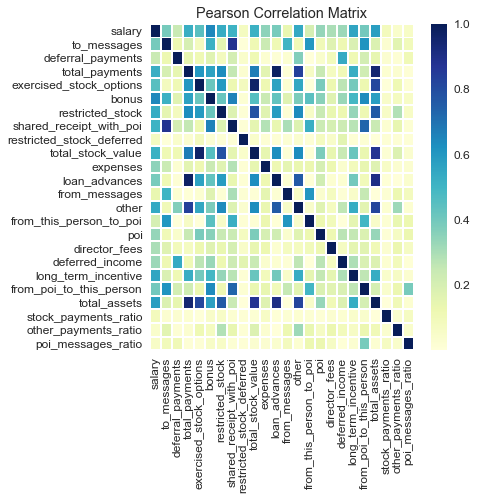

In [15]:
prj.plot_correlation_matrix(df)

In [16]:
# top 10 correlations between poi and other features
df.corr()['poi'].abs().sort_values(ascending=False)[1:][:10]

exercised_stock_options    0.386637
total_stock_value          0.381059
bonus                      0.356648
salary                     0.336238
total_assets               0.333597
deferred_income            0.272896
long_term_incentive        0.254446
total_payments             0.247616
restricted_stock           0.244842
shared_receipt_with_poi    0.237893
Name: poi, dtype: float64

### Feature Selection

In [17]:
# split features and target labels
features, labels = prj.split_features_labels(df)

In [18]:
# top 10 SelectKBest feature scores
prj.select_features_by_kbest(features, labels)

[['exercised_stock_options', 24.431067695915822],
 ['total_stock_value', 23.612288926893026],
 ['bonus', 20.25718499812395],
 ['salary', 17.717873579243289],
 ['total_assets', 17.405962336723121],
 ['deferred_income', 11.184580251839124],
 ['long_term_incentive', 9.6222121643046794],
 ['total_payments', 9.079275477352267],
 ['restricted_stock', 8.8641107260620533],
 ['shared_receipt_with_poi', 8.3383403168813857]]

In [19]:
# Decision Tree: features selection by feature importances
prj.select_features_by_decision_tree(features, labels)

[['exercised_stock_options', 0.19951338199513408],
 ['other', 0.13922732620960848],
 ['restricted_stock', 0.12067655716988449],
 ['total_payments', 0.11321890996687742],
 ['bonus', 0.10847765543158015],
 ['from_this_person_to_poi', 0.087437855730538777],
 ['expenses', 0.06475598369429085],
 ['shared_receipt_with_poi', 0.057896033505789611],
 ['from_poi_to_this_person', 0.055724932249322498],
 ['poi_messages_ratio', 0.053071364046973803]]

In [20]:
# PCA: features selection by principal component analysis
prj.select_features_by_pca(features, labels)

[['salary', 0.90388757995391666],
 ['to_messages', 0.076694971042350693],
 ['deferral_payments', 0.0084153702819643409],
 ['total_payments', 0.0060339585665983818],
 ['exercised_stock_options', 0.0022743437413857751],
 ['bonus', 0.00111177268221296],
 ['restricted_stock', 0.0006882693846297762],
 ['shared_receipt_with_poi', 0.00040861921594994872],
 ['restricted_stock_deferred', 0.00033977659995395757],
 ['total_stock_value', 9.731850425790688e-05]]

In [21]:
# RFE: feature ranking with recursive feature elimination
# using logistic regression
prj.select_features_by_rfe(features, labels)

[['to_messages', 1],
 ['total_payments', 1],
 ['exercised_stock_options', 1],
 ['restricted_stock', 1],
 ['shared_receipt_with_poi', 1],
 ['restricted_stock_deferred', 1],
 ['total_stock_value', 1],
 ['from_this_person_to_poi', 1],
 ['director_fees', 1],
 ['total_assets', 1]]

In [22]:
### check and compare feature selection of the original feature set
# clean df
original_df = original_df.fillna(0)

# split features and target labels
features, labels = prj.split_features_labels(original_df)

# top 10 SelectKBest feature scores
prj.select_features_by_kbest(features, labels)

[['exercised_stock_options', 24.431067695915822],
 ['total_stock_value', 23.612288926893026],
 ['bonus', 20.25718499812395],
 ['salary', 17.717873579243289],
 ['deferred_income', 11.184580251839124],
 ['long_term_incentive', 9.6222121643046794],
 ['total_payments', 9.079275477352267],
 ['restricted_stock', 8.8641107260620533],
 ['shared_receipt_with_poi', 8.3383403168813857],
 ['loan_advances', 7.0667108613197493]]

### Feature Scaling

In [23]:
# scaled top 5 kbest features using MinMaxScaler
scaled_df = prj.normalize(df)
top5_df = scaled_df[[
    'exercised_stock_options',
    'total_stock_value',
    'bonus',
    'salary',
    'total_assets',
    'poi'
]]
top5_df.describe()

C:\dev\anaconda\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


,exercised_stock_options,total_stock_value,bonus,salary,total_assets,poi
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.00000
mean,0.061181,0.060517,0.086298,0.170430,0.032750,0.12766
std,0.140909,0.127061,0.155285,0.177496,0.091054,0.33490
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.006488,0.000000,0.000000,0.001044,0.00000
50%,0.017723,0.020058,0.037500,0.190584,0.013563,0.00000
75%,0.048569,0.047493,0.100000,0.244266,0.030538,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


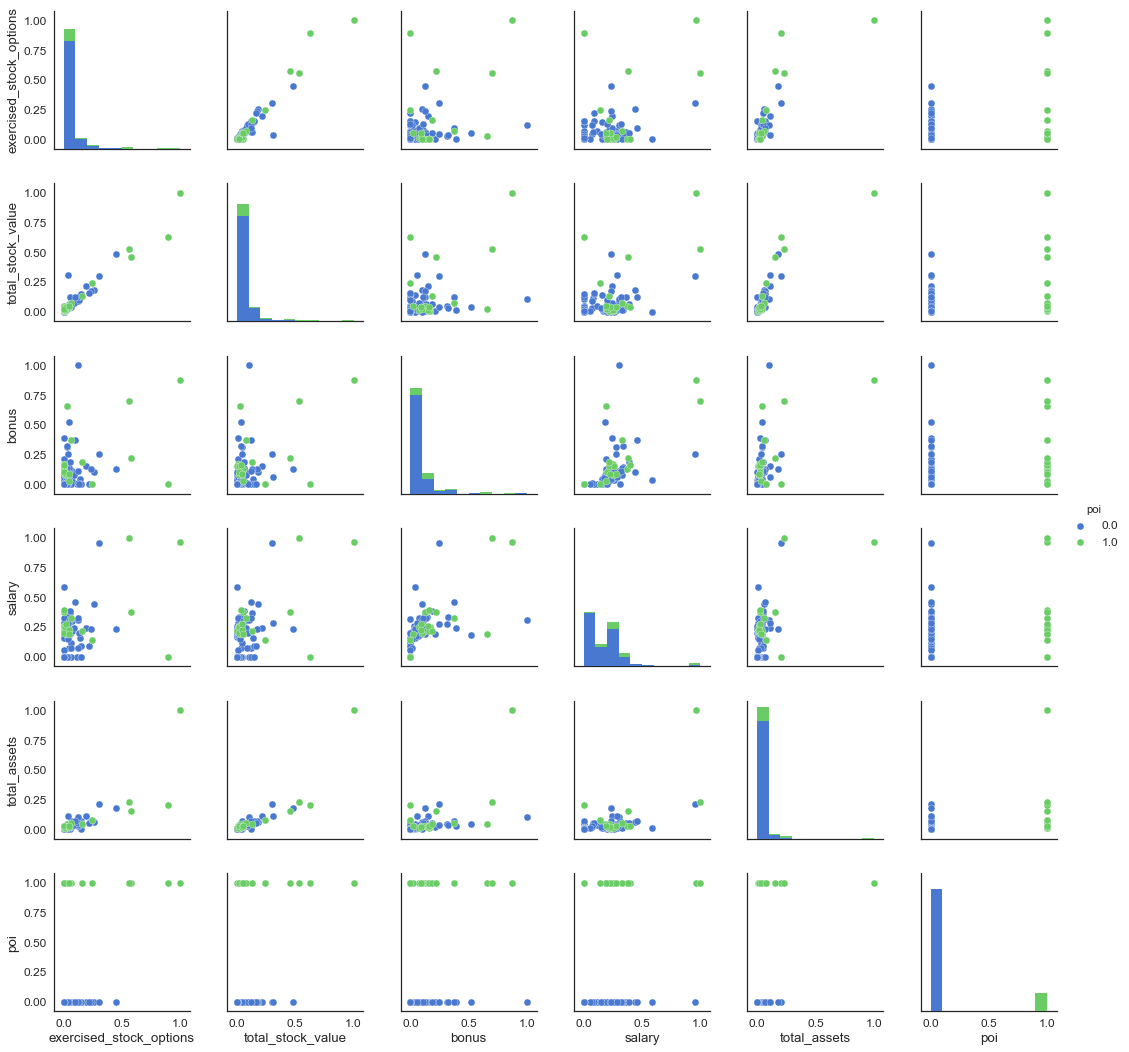

In [24]:
# get a deeper touch of feature dependencies and distributions after scaling
sns.pairplot(data=top5_df, hue='poi')

## Question 3: Pick & Test Algorithms

**Question 3**: What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?

> To pick the right algorithm we built a generic _pipeline_ function combined with parameter estimation using _grid search with cross-validation_ and _f1_ scoring. We compared different classfication algorithms using the following steps:
* **Create Pipeline**: Each feature was scaled at the beginning using the _MinMaxScaler_, then a parameterized number of features were selected by SelectKBest, PCA or RFE and eventually run under different classifiers using an exhaustive search over specified parameter values.
* **Train Pipeline**: In the next step we used _StratifiedShuffleSplit_ to randomly split (with *n_splits* = 10, *test_size* = .3 and *train_size* = .7) the pipeline into train and test partitions and then fitted it using _GridSearchCV_.
* **Evaluate Pipeline**: The best classifier and parameters of each pipeline was then passed to the evaluation function to test its performance metrics such as accuracy, precision, recall and f1. The records were additionaly splitted and evaluated with the same parameters like used in the _tester.py_ to guarantee the best results.
> 
**Final Algorithm**: **_LogisticRegression_** was the best algorithm to identify POI and provided the best validation results.
> 
**Algorithms Tried**: The other algorithms tested were _DecisionTreeClassifier_, _RandomForestClassifier_, _KNeighborsClassifier_, _LogisticRegression_, _GaussianNB_, _AdaBoostClassifier_ and _SVC_. All of them performed adequately in one aspect or another. We picked _LogisticRegression_ because it had the highest **_recall_** and **_precision_** scores. (Note: Rationale for this is explained in _Question 6_.)
> 
**Comparison of Performance Metrics**:
>
| **_Estimator_** | **_accuracy_** | **_precision_** | **_recall_** | **_f1_** | **_f2_** |
|-----------------|----------------|-----------------|--------------|----------|----------|
| **LogisticRegression**     | .76 | .31 | .62 | .41 | .52 |
| RandomForestClassifier | .86 | .50 | .27 | .35 | .30 |
| GaussianNB             | .84 | .39 | .30 | .34 | .32 |
| DecisionTreeClassifier | .78 | .27 | .38 | .31 | .35 |
| KNeighborsClassifier   | .87 | .61 | .15 | .24 | .17 |
| SVC                    | .84 | .30 | .19 | .23 | .20 |
| AdaBoostClassifier     | .81 | .21 | .15 | .18 | .16 |
>
**Evaluation using the Original Feature Set** (without new features): When the _LogisticRegression_ algorithm was trained using the the original feature set, it showed far worse performance metrics. The _recall_ had a value below the required 0.3 limit. Then we evaluated the final algorithm with the original feature set. This time the metrics were slightly better than the features list containing new features. The reason was that the PCA had another composition and somewhat different explained variances when using the complete features set. Therefore in the final output the original feature list is used instead.
> 
| **_Estimator_** | **_accuracy_** | **_precision_** | **_recall_** | **_f1_** | **_f2_** |
|-----------------|----------------|-----------------|--------------|----------|----------|
| LogisticRegression (final algorithm)    | .76 | .31 | .62 | .41 | .52 |
| LogisticRegression (trained with original features)    | .87 | .55 | .16 | .25 | .19 |
| LogisticRegression (final algorithm on original features)    | .77 | **.32** | **.63** | .42 | .52 |


### Algorithm Research & Selection

* Scikit-learn algorithms for supervised with non-ordered or discrete data:
    * Decision Tree
    * Naive Bayes
    * SVM
    * kNN
    * LDA
    * Logistic Regression

### Algorithm Pipelines

- Pipeline Construction:

> Pipeline(steps=[
>
>     ('scale', scaler),
>
>     ('reduce', reducer),
>
>     ('classify', classifier)
>
> ])

- Pipeline and GridSearchCV parameters:
    * **Scaler**:
        * MinMaxScaler
    * **Reducer** (Feature Selector): 
        * SelectKBest:
            * score_func: [f_classif, chi2, f_regression]
            * k: range(1, 5)
        * PCA:
            * n_components: range(1, 5)
        * RFE:        
            * n_features_to_select: range(1, 5)
    * **Classifier**:
        * DecisionTreeClassifier:
            * max_depth: range(2, 8)
            * min_samples_leaf: range(1, 5)
            * class_weight: ['balanced']
            * criterion: ['gini', 'entropy']
        * RandomForestClassifier:
            * n_estimators: range(2, 20, 5)
            * min_samples_split: range(2, 12, 3)
            * max_depth: range(2, 5)
            * criterion: ['gini', 'entropy']
        * KNeighborsClassifier:
            * n_neighbors: range(1, 10)
            * leaf_size: range(1, 30, 5)
            * algorithm: ['auto', 'ball_tree', 'kd_tree', 'brute']
        * LogisticRegression
            * class_weight: [None, 'balanced']
            * solver: ['liblinear', 'sag']
            * C: range(1, 5)
        * GaussianNB
        * AdaBoostClassifier (decision tree):
            * n_estimators: range(10, 50, 10)
            * algorithm: ['SAMME', 'SAMME.R']
            * learning_rate: [.8, 1.0, 1.2, 1.5]
        * SVC:
            * kernel: ['rbf', 'linear']
            * C: [1.0, 2.0, 10.0, 100.0]
            * gamma: ['auto', 2.0, 10.0]

In [25]:
# create and test pipline using support vector classification
from sklearn.svm import SVC
pipe = prj.create_pipeline(SVC())
params = {
    'kernel': ['rbf', 'linear'],
    'C': [1, 10, 100, 1000],
    'gamma': ['auto', 1.0, 5.0, 10.0]
}
pipe_result = prj.train_pipeline(df, pipe, params)
prj.evaluate_pipeline(df, pipe_result)

Estimator: SVC
> selected features: ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value']
> scaler params:
    scale=MinMaxScaler(copy=True, feature_range=(0, 1))
> dimension reducer params:
    reduce__n_components=20
    reduce=PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)
> estimator params:
    classify__C=1000
    classify__gamma=auto
    classify__kernel=linear

Performance metrics (train):
> accuracy=0.92, precision=0.89, recall=0.44, f1=0.59

Performance metrics (tester.py):
Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce', PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shap

In [25]:
# create and test pipline using decision tree classifier
from sklearn.tree import DecisionTreeClassifier
pipe = prj.create_pipeline(DecisionTreeClassifier())
params = {
    'max_depth': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy']
}
pipe_result = prj.train_pipeline(df, pipe, params)
prj.evaluate_pipeline(df, pipe_result)

Estimator: DecisionTreeClassifier
> selected features: ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value']
> scaler params:
    scale=MinMaxScaler(copy=True, feature_range=(0, 1))
> dimension reducer params:
    reduce__n_components=20
    reduce=PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)
> estimator params:
    classify__max_depth=5
    classify__class_weight=balanced
    classify__criterion=gini
    classify__min_samples_leaf=1

Performance metrics (train):
> accuracy=0.96, precision=0.77, recall=0.94, f1=0.85

Performance metrics (tester.py):
Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce', PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', DecisionTreeC

In [26]:
# create and test pipline using decision tree classifier
from sklearn.ensemble import RandomForestClassifier
pipe = prj.create_pipeline(RandomForestClassifier())
params = {
    'n_estimators': [2, 5, 10],
    'min_samples_split': [2, 3, 5],
    'max_depth': [None, 2, 5],
    'criterion': ['gini', 'entropy']
}
pipe_result = prj.train_pipeline(df, pipe, params)
prj.evaluate_pipeline(df, pipe_result)

Estimator: RandomForestClassifier
> selected features: ['exercised_stock_options', 'bonus', 'total_stock_value', 'loan_advances']
> scaler params:
    scale=MinMaxScaler(copy=True, feature_range=(0, 1))
> dimension reducer params:
    reduce__score_func=<function chi2 at 0x08D221F0>
    reduce=SelectKBest(k=4, score_func=<function chi2 at 0x08D221F0>)
    reduce__k=4
> estimator params:
    classify__n_estimators=10
    classify__min_samples_split=3
    classify__criterion=gini
    classify__max_depth=5

Performance metrics (train):
> accuracy=0.97, precision=1.00, recall=0.78, f1=0.88

Performance metrics (tester.py):
Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce', SelectKBest(k=4, score_func=<function chi2 at 0x08D221F0>)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
       ...stimators=10, n_jobs=1, oob_score=False, random_state=42,
   

In [27]:
# create and test pipline using kneighbors classifier
from sklearn.neighbors import KNeighborsClassifier
pipe = prj.create_pipeline(KNeighborsClassifier())
params = {
    'n_neighbors': [2, 5, 8],
    'leaf_size': [5, 10, 30],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}
pipe_result = prj.train_pipeline(df, pipe, params)
prj.evaluate_pipeline(df, pipe_result)

Estimator: KNeighborsClassifier
> selected features: ['total_payments', 'exercised_stock_options', 'bonus', 'total_stock_value', 'loan_advances', 'total_assets']
> scaler params:
    scale=MinMaxScaler(copy=True, feature_range=(0, 1))
> dimension reducer params:
    reduce__score_func=<function chi2 at 0x08D221F0>
    reduce=SelectKBest(k=6, score_func=<function chi2 at 0x08D221F0>)
    reduce__k=6
> estimator params:
    classify__n_neighbors=2
    classify__algorithm=auto
    classify__leaf_size=5

Performance metrics (train):
> accuracy=0.92, precision=1.00, recall=0.39, f1=0.56

Performance metrics (tester.py):
Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce', SelectKBest(k=6, score_func=<function chi2 at 0x08D221F0>)), ('classify', KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform'))])
	Accuracy: 0.87353	Precision: 0.60707	Recall: 0.1460

In [25]:
# create and test pipline using logistic regression
from sklearn.linear_model import LogisticRegression
pipe = prj.create_pipeline(LogisticRegression())
params = {
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'sag'],
    'C': [1, 5, 10]
}
pipe_result = prj.train_pipeline(df, pipe, params)
prj.evaluate_pipeline(df, pipe_result)

Estimator: LogisticRegression
> selected features: ['salary', 'to_messages']
> scaler params:
    scale=MinMaxScaler(copy=True, feature_range=(0, 1))
> dimension reducer params:
    reduce__n_components=2
    reduce=PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)
> estimator params:
    classify__C=10
    classify__solver=liblinear
    classify__class_weight=balanced

Performance metrics (train):
> accuracy=0.79, precision=0.32, recall=0.61, f1=0.42

Performance metrics (tester.py):
Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce', PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol

In [25]:
# create and test pipline using gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
pipe = prj.create_pipeline(GaussianNB())
params = {}
pipe_result = prj.train_pipeline(df, pipe, params)
prj.evaluate_pipeline(df, pipe_result)

Estimator: GaussianNB
> selected features: ['exercised_stock_options', 'bonus', 'total_stock_value', 'expenses', 'deferred_income']
> scaler params:
    scale=MinMaxScaler(copy=True, feature_range=(0, 1))
> dimension reducer params:
    reduce__n_features_to_select=5
    reduce=RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=5, step=1, verbose=0)
> estimator params:

Performance metrics (train):
> accuracy=0.87, precision=0.50, recall=0.39, f1=0.44

Performance metrics (tester.py):
Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce', RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
        

In [26]:
# create and test pipline using ada boost classifier with the default decision tree base estimator
from sklearn.ensemble import AdaBoostClassifier
pipe = prj.create_pipeline(AdaBoostClassifier())
params = {
    'n_estimators': [2, 5, 10, 20],
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': [.6, 1.0, 1.4]
}
pipe_result = prj.train_pipeline(df, pipe, params)
prj.evaluate_pipeline(df, pipe_result)

Estimator: AdaBoostClassifier
> selected features: ['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value']
> scaler params:
    scale=MinMaxScaler(copy=True, feature_range=(0, 1))
> dimension reducer params:
    reduce__n_components=20
    reduce=PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)
> estimator params:
    classify__learning_rate=1.4
    classify__n_estimators=2
    classify__algorithm=SAMME.R

Performance metrics (train):
> accuracy=0.89, precision=0.57, recall=0.44, f1=0.50

Performance metrics (tester.py):
Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce', PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', AdaBoostClassifier(algorithm='SAMME.R', base_est

### Performance Comparison

**Performance Metrics**:

| **_Estimator_** | **_accuracy_** | **_precision_** | **_recall_** | **_f1_** | **_f2_** |
|-----------------|----------------|-----------------|--------------|----------|----------|
| **LogisticRegression**     | .76 | .31 | .62 | .41 | .52 |
| RandomForestClassifier | .86 | .50 | .27 | .35 | .30 |
| GaussianNB             | .84 | .39 | .30 | .34 | .32 |
| DecisionTreeClassifier | .78 | .27 | .38 | .31 | .35 |
| KNeighborsClassifier   | .87 | .61 | .15 | .24 | .17 |
| SVC                    | .84 | .30 | .19 | .23 | .20 |
| AdaBoostClassifier     | .81 | .21 | .15 | .18 | .16 |

**Performance of the Original Feature Set** (without new features):

| **_Estimator_** | **_accuracy_** | **_precision_** | **_recall_** | **_f1_** | **_f2_** |
|-----------------|----------------|-----------------|--------------|----------|----------|
| LogisticRegression (final algorithm)    | .76 | .31 | .62 | .41 | .52 |
| LogisticRegression (trained with original features)    | .87 | .55 | .16 | .25 | .19 |
| LogisticRegression (final algorithm on original features)    | .77 | **.32** | **.63** | .42 | .52 |


In [27]:
### recheck original feature set
# evaluation of the final algorithm without new features
from sklearn.linear_model import LogisticRegression
pipe = prj.create_pipeline(LogisticRegression())
params = {
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'sag'],
    'C': [1, 5, 10]
}
pipe_result = prj.train_pipeline(original_df, pipe, params)
prj.evaluate_pipeline(original_df, pipe_result)

Estimator: LogisticRegression
> selected features: ['salary', 'to_messages', 'deferral_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses']
> scaler params:
    scale=MinMaxScaler(copy=True, feature_range=(0, 1))
> dimension reducer params:
    reduce__n_features_to_select=17
    reduce=RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=17, step=1, verbose=0)
> estimator params:
    classify__C=10
    classify__solver=liblinear
    classify__class_weight=None

Performance metrics (train):
> accuracy=0.90, precision=0.83, recall=0.28, f1=0.42

Performance metrics (tester.py):
Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range

In [31]:
# use final algorithm with original feature set
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
clf = Pipeline(steps=[
    ('scale', MinMaxScaler()), 
    ('reduce', PCA(n_components=2, random_state=42)), 
    ('classify', LogisticRegression(C=10, class_weight='balanced', random_state=42, solver='liblinear'))
])
prj.run_tester_check(original_df, clf, list(original_df.drop('poi', axis=1).columns))

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce', PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
	Accuracy: 0.77280	Precision: 0.32004	Recall: 0.62600	F1: 0.42355	F2: 0.52552
	Total predictions: 15000	True positives: 1252	False positives: 2660	False negatives:  748	True negatives: 10340



### Final Pick

* Most explained features by PCA: '**salary**', '**to_messages**'
* Pipeline: 
> Pipeline(steps=[
>     ('scale', MinMaxScaler()), 
>     ('reduce', PCA(n_components=2, random_state=42)), 
>     ('classify', LogisticRegression(C=10, class_weight='balanced', random_state=42, solver='liblinear'))
> ])

## Question 4: Tune Parameters

**Question 4**: What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).

> **Parameter Tuning**: Most machine learning algorithms have parameters provided with default values and do work without any fine-tuning. But the best result for a given model is only guaranteed by optimization its parameters. The tuning process also allows us to select the optimal model by comparing the performance scores like recall or f1 and select the best one for use. We used the grid search process with cross-validation to perform the parameter tuning for pre-defined set of parameter values and for the selected algorithms and to evalutate all kind of combinations of those values in order to be assured that the actual best model is selected.
>
> **Parameters Tuned**: As described in the previous answer the parameters of the pipelines were tuned via GridSearchCV parameter grid. The main work was to pre-define the set of parameters available for the preselection and classification algorithms. For the final algorithm the following parameters were tuned:
* [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html):
    * *n_components*: values trained were *range(1, 8)*. *PCA* is a linear dimensionality reduction algortihm to project data to a lower dimensional space. _n_components_ is the number of components to keep.
Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.
        * selected parameter value: **n_components = 2**
* [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html):
    * *C*: values trained were *[1, 5, 10]*. It represents a regularization strength like in C in the SVM.
        * selected parameter value: **C = 10**
    * *solver*: values trained were '*liblinear*' and '*sag*'. It's the underlying regularized logistic regression libraries.
        * selected parameter value: **solver = 'liblinear'**
    * *class_weight*: values trained were *[None, 'balanced']*.
        * selected parameter value: **class_weight = 'balanced'**

## Question 5: Validate Algorithm

**Question** 5: What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?

> **Purpose of Validation**: Validation is performed to test how well the algorithm has been trained and to ensure that the trained model generalizes well. A good validation process tries to find a valid compromise between bias and variance.
> 
> **Classic Mistake**: A classic mistake in validation is the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). 
* Overfitting: Algorithm with high-variance tends to represent the training set well, but is at risk of overfitting to noisy or unrepresentative training data . 
* Underfitting: Models with high bias in the another hand can produce simpler models which don't tend to overfit, but may miss the relevant relations between features and target outputs (_underfitting_) .
> 
> **Validation Process**: The algorithms analyzed in this report used GridSearchCV combined with StratifiedShuffleSplit to randomly split the data into multiple train and test sets. The test size was 30%, while the training set was set to 70%. The best pipeline of each grid search result was then double validated by the *print_metrics* method from the 'p5_ml_enron.py' script file and at last by the *test_classifier* method provided in the 'tester.py'.


## Question 6: Evaluate Algorithm


**Question 6**: Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.

**Evaluation Metrics**: During the evaluation of the algorithms four performance metrics were calculated and compared.
* _Accuracy_: Proportion of all predictions that are correct. Accuracy is a measurment of how good a model is.
$$accuracy = \frac{TP+FN}{TP+FN+TP+TN} = \frac{\text{correct predictions}}{\text{all predictions}}$$
* _Precision_: Proportion of all positive predictions that are correct. Precision is a measure of how many positive predictions were actual positive observations.
$$Precision = \frac{TP}{TP+FP} = \frac{\text{positive predicted correctly}}{\text{all positive predictions}}$$
* _Recall_: Proportion of all real positive observations that are correct. Precision is a measure of how many actual positive observations were predicted correctly.
$$Recall = TPR = \frac{TP}{TP+FN} = \frac{TP}{P} = \frac{\text{predicted to be positive}}{\text{all positive observations}}$$
* _F1 score_: The harmonic mean of precision and recall. F1 score is an 'average' of both precision and recall. We use the harmonic mean because it is the appropriate way to average ratios (while arthmetric mean is appropriate when it conceptually makes sense to add things up).
$$F1 = 2\frac{Precision * Recall}{Precision + Recall}$$

**Performance** of the final _LogisticRegression_ algorithm:
* _Accuracy_: .76 (76%)		 	
* _Precision_: .31 (31%)
* _Recall_: .62 (62%)
* _f1_: .41 (41%)

**Interpretation of the metrics**: The pipelines in the experiment used precision and recall to evaluate the performance in predicting POIs. (F1 score is the combination of both.) The metric _accuracy_ was left out because it's not ideal when dealing with skewed data. With a non-POI ratio of over 87% like in this data set we would get an accuracy of 87% if we would predict that every person was non-POI.
* _Precision_ in this project: The final model's precision was approximately 31% and says that from the people classified as POI, 31% of them are true POI.
* _Recall_ in this project: However, its recall value is over 62% refering that from the number of all POI in the total data set, the model correctly identifies 62% of them.
In a real-world application like in the enron case, a _recall_ being higher than _precision_ score means that more real POI are captured by the algorithm but also more people are mis-identified as a POI. 

## Dump Tester Results


> Performance metrics (tester.py):
>
> Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reduce', PCA(copy=True, iterated_power='auto', n_components=2, random_state=42, svd_solver='auto', tol=0.0, whiten=False)), ('classify', LogisticRegression(C=10, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2', random_state=42, solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])
>
> Accuracy: 0.77280	Precision: 0.32004	Recall: 0.62600	F1: 0.42355	F2: 0.52552
> 
> Total predictions: 15000	True positives: 1252	False positives: 2660	False negatives:  748	True negatives: 10340

## References

* [Scikit-learn documentation](http://scikit-learn.org/stable)
* [Scikit-learn: Feature Selection](http://scikit-learn.org/stable/modules/feature_selection.html)
* [Pandas documentation](http://pandas.pydata.org/pandas-docs/version/0.19.2)
* [Seaborn documentation](https://seaborn.pydata.org/api.html)
* [Wikipedia: Bias-Variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)

## Reproduction Environment

In [ ]:
import IPython
print IPython.sys_info()

In [ ]:
!pip freeze